## 데이터 수집

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import seaborn as sns
import pandas as pd
import numpy as np 
import scipy.stats as stats
from sklearn import datasets 
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score #, root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from copy import deepcopy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import lightgbm as lgb

In [3]:
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [4]:
!fc-list | grep "NanumGothic"

/usr/share/fonts/truetype/nanum/NanumGothic.ttf: NanumGothic,나눔고딕:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf: NanumGothicCoding,나눔고딕코딩:style=Regular
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf: NanumGothic,나눔고딕:style=Bold
/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold


In [5]:
import matplotlib.font_manager as fm
# 폰트 캐시 삭제 및 재생성
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
fm._load_fontmanager(try_read_cache=False)

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
data_df = pd.read_csv('../../datasets/LetalCarOfContractType.csv')
data_df.head()

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
0,66758234,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,9.0,새마을금고,정상,43.0,1862.0
1,66755948,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,카드이체,K1,102900,계약확정,0,없음,2.0,현대카드,정상,62.0,2532.0
2,66756657,렌탈,Normal,홈쇼핑/방송,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,8.0,우리은행,정상,60.0,2363.0
3,66423450,멤버십,TAS,렌탈재계약,2019-10-20,12,CMS,K1,66900,계약확정,0,없음,5.0,농협은행,정상,60.0,2449.0
4,66423204,멤버십,TAS,렌탈재계약,2019-10-20,12,CMS,K1,66900,해약확정,12,있음,8.0,농협은행,해약,51.0,1942.0


## 데이터 분석

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 51304 non-null  int64  
 1   type_of_contract   51300 non-null  object 
 2   type_of_contract2  51303 non-null  object 
 3   channel            51304 non-null  object 
 4   datetime           51304 non-null  object 
 5   Term               51304 non-null  int64  
 6   payment_type       51304 non-null  object 
 7   product            51303 non-null  object 
 8   amount             51304 non-null  int64  
 9   state              51304 non-null  object 
 10  overdue_count      51304 non-null  int64  
 11  overdue            51302 non-null  object 
 12  credit rating      42521 non-null  float64
 13  bank               48544 non-null  object 
 14  cancellation       51279 non-null  object 
 15  age                40509 non-null  float64
 16  Mileage            405

##### 결측치 정리 
- type_of_contract : "렌탈" 로 채우면 됨
- type_of_contract2 : 'channel == "홈쇼핑/방송"''amount == 81900''datetime == "2019-10-21"''product == "K2"' 면 전부 Packge 였음
- product : 더 조건 필요 K1 > K2 많았음
- overdue : overdue_count == 0 이면 "없음", overdue_count == 2 면 "있음"
- credit rating : 없으면 age, Mileage 없다
- bank : credit rating : 3.0 1 1.0 1, age : 20.0 1 51.0 1, Mileage
1217.0 1 2217.0 1
- cancellation : "정상"으로 채우면 될듯
- age : Mileage랑 같이 없다
- Mileage : age랑 같이 없다

In [8]:
data_df['Mileage']

0        1862.0
1        2532.0
2        2363.0
3        2449.0
4        1942.0
          ...  
51299       NaN
51300    1753.0
51301    2217.0
51302    2588.0
51303    2130.0
Name: Mileage, Length: 51304, dtype: float64

In [9]:
data_df[data_df['Mileage'].isna()]

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
7,66751017,렌탈,Package,홈쇼핑/방송,2019-10-20,60,카드이체,K2,80400,계약확정,0,없음,1.0,롯데카드,정상,NaN,NaN
19,66758336,렌탈,Promotion,전자랜드,2019-10-20,60,CMS,K1,111900,계약확정,0,없음,9.0,농협은행,정상,NaN,NaN
21,66758074,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K2,87900,계약확정,0,없음,1.0,국민은행,정상,NaN,NaN
26,66419239,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,NaN,국민은행,정상,NaN,NaN
27,25702131,멤버십,TAS,렌탈재계약,2019-10-20,12,CMS,K1,66900,계약확정,0,없음,NaN,기업은행,정상,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51289,66799221,멤버십,TA2,하이마트,2020-02-03,36,무통장,K1,56979,해약확정,0,없음,NaN,NaN,해약,NaN,NaN
51291,66796007,렌탈,Promotion,R관리방판,2020-02-03,60,카드이체,K3,90900,계약확정,0,없음,NaN,BC카드,정상,NaN,NaN
51293,66579515,렌탈,Promotion,R관리방판,2020-02-03,60,CMS,K3,96900,계약확정,0,없음,NaN,기업은행,정상,NaN,NaN
51298,66796621,멤버십,TA2,R관리방판,2020-02-03,36,CMS,K1,56979,계약확정,0,없음,NaN,롯데카드,정상,NaN,NaN


In [10]:
data_df['Mileage'].value_counts()

Mileage
2030.0    53
1814.0    50
1775.0    50
2010.0    48
1944.0    47
          ..
3127.0     1
3091.0     1
3031.0     1
3284.0     1
3280.0     1
Name: count, Length: 2297, dtype: int64

In [11]:
bank_df = data_df[
    data_df['age'].notna() & 
    data_df['credit rating'].isna()
]
bank_df

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage


In [12]:
temp = data_df[data_df['cancellation'].isna()]
temp['state'].value_counts()

state
계약확정    24
기간만료     1
Name: count, dtype: int64

In [13]:
data_df['cancellation'].value_counts()

cancellation
정상    50372
해약      907
Name: count, dtype: int64

In [14]:
data_df['state'].value_counts()

state
계약확정     50350
해약확정       907
기간만료        33
해약진행중       14
Name: count, dtype: int64

In [15]:
condition_state = 'state == "계약확정"'
condition_cancellation = 'cancellation == "기간만료"'
temp = data_df.query(
    f"{condition_state}"
)
temp['cancellation'].value_counts()

cancellation
정상    50326
Name: count, dtype: int64

In [16]:
condition_overdue_count = 'overdue_count == -1'
temp = data_df.query(
    f"{condition_overdue_count}"
)
temp['overdue'].value_counts()

overdue
없음    17
Name: count, dtype: int64

In [17]:
condition_overdue_count = 'overdue_count != 0'
condition_overdue = 'overdue == "없음"'
temp = data_df.query(
    f"{condition_overdue_count} and "
    f"{condition_overdue}"
)
temp['overdue'].value_counts()
temp.head()

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
1789,66760179,렌탈,Promotion,홈쇼핑/방송,2019-10-23,60,카드이체,K1,96900,계약확정,-1,없음,1.0,롯데카드,정상,50.0,2107.0
1795,66674030,렌탈,Promotion,서비스 방문,2019-10-23,60,CMS,K2,90900,계약확정,-1,없음,1.0,신한은행,정상,46.0,1946.0
1816,66759728,렌탈,Normal,영업방판,2019-10-23,60,CMS,K1,87900,계약확정,-1,없음,NaN,국민은행,정상,NaN,NaN
1859,66757586,렌탈,Normal,서비스 방문,2019-10-23,60,CMS,K1,96900,계약확정,-1,없음,2.0,농협은행,정상,65.0,2511.0
1901,66759913,렌탈,Promotion,홈쇼핑/방송,2019-10-23,60,카드이체,K1,96900,계약확정,-1,없음,1.0,롯데카드,정상,48.0,2151.0


In [18]:
condition_type_of_contract = 'type_of_contract == "렌탈"'
condition_type_of_contract2 = 'type_of_contract2 == "Normal"'
condition_channel = 'channel == "홈쇼핑/방송"'
condition_product = 'product == "K2"'
condition_amount = 'amount == 96900'
condition_datetime = 'datetime == "2019-10-21"'

temp = data_df.query(
    f"{condition_channel} and "
    f"{condition_type_of_contract2} and "
    f"{condition_amount} and "
    f"{condition_datetime}"
)
temp.head()


,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
31,66758778,렌탈,Normal,홈쇼핑/방송,2019-10-21,60,CMS,K1,96900,계약확정,0,없음,5.0,우리은행,정상,64.0,2409.0
35,66528773,렌탈,Normal,홈쇼핑/방송,2019-10-21,60,CMS,K1,96900,계약확정,0,없음,3.0,국민은행,정상,65.0,2375.0
43,66758431,렌탈,Normal,홈쇼핑/방송,2019-10-21,60,카드이체,K1,96900,계약확정,0,없음,1.0,국민카드,정상,52.0,2131.0
91,66758611,렌탈,Normal,홈쇼핑/방송,2019-10-21,60,카드이체,K1,96900,계약확정,0,없음,1.0,신한카드,정상,32.0,1551.0
107,66758509,렌탈,Normal,홈쇼핑/방송,2019-10-21,60,카드이체,K1,96900,계약확정,0,없음,1.0,신한카드,정상,76.0,2925.0


In [19]:
def split_categorical_numerical(df, unique_threshold=0.001):
    """
    데이터프레임을 범주형과 수치형으로 분리
    
    Parameters:
    - df: 입력 데이터프레임
    - unique_threshold: unique 값 비율 임계값 (기본값 0.05 = 5%)
    
    Returns:
    - categorical_df: 범주형 컬럼만 있는 데이터프레임
    - numerical_df: 수치형 컬럼만 있는 데이터프레임
    """
    
    categorical_cols = []
    numerical_cols = []
    
    n_rows = len(df)
    
    for col in df.columns:
        # unique 값의 비율 계산
        unique_ratio = len(df[col].unique()) / n_rows
        n_unique = df[col].nunique()
        # object 타입이거나, unique 값 비율이 임계값보다 작으면 범주형으로 분류
        # df[col].dtype == 'object' or
        # if unique_ratio < unique_threshold:
        if n_unique < 30:  
            # print(f'cat - {col} : {n_unique}, {unique_ratio}')
            categorical_cols.append(col)
        else:
            # print(f'num - {col} : {n_unique}, {unique_ratio}')
            numerical_cols.append(col)
            
    return df[categorical_cols], df[numerical_cols]

##### label 선택 추가 고려 사항
- label은 feature들에 대해 종속적이야 한다.
- feature 들 간에 관계는 독립적이여야 한다.
- ex) 두 feature 가 종속 관계 라면 한 feature를 빼는 것이 좋다. 가중치가 높아지기 때문
- ex2) label 과 feature 간에는 종속적이여도 상관 없다. 다른 독립적 feature 의 영향에 따라 label에 대한 예측이 달라질 수 있기 때문. 
- 다만 해당 feature에 대해 의도적으로 가중치를 줄이는 방법이 필요한 지에 대해 고려 필요 


In [20]:
cat_df, num_df = split_categorical_numerical(data_df)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_of_contract   51300 non-null  object 
 1   type_of_contract2  51303 non-null  object 
 2   channel            51304 non-null  object 
 3   Term               51304 non-null  int64  
 4   payment_type       51304 non-null  object 
 5   product            51303 non-null  object 
 6   state              51304 non-null  object 
 7   overdue_count      51304 non-null  int64  
 8   overdue            51302 non-null  object 
 9   credit rating      42521 non-null  float64
 10  cancellation       51279 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.3+ MB


##### 강한 관계 쌍 
- 아주 강한 쌍 (거의 1)
+ type_of_contract - type_of_contract2
+ overdue - overdue_count
+ state - cancellation
- 약간 강한 쌍 (0.8~0.9)
+ type_of_contract - Term
+ type_of_contract - channel

In [21]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# 사용 예시
correlation = cramers_v(data_df['state'], data_df['cancellation'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.9999999999999999


In [22]:
correlation = cramers_v(data_df['type_of_contract'], data_df['type_of_contract2'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 1.0


In [23]:
# data_df['overdue_count'] = data_df['overdue_count'].astype(str)
# correlation = cramers_v(data_df['overdue'], data_df['overdue_count'])
# print(f"Cramer's V correlation: {correlation}")

In [24]:
correlation = cramers_v(data_df['type_of_contract'], data_df['overdue'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.033128307757429136


In [25]:
correlation = cramers_v(data_df['type_of_contract'], data_df['channel'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.8572452417492489


In [26]:
correlation = cramers_v(data_df['type_of_contract2'], data_df['channel'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.6033790432502193


In [27]:
correlation = cramers_v(data_df['type_of_contract2'], data_df['Term'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.7438052367165258


In [28]:
correlation = cramers_v(data_df['type_of_contract'], data_df['Term'])
print(f"Cramer's V correlation: {correlation}")

Cramer's V correlation: 0.9080832573638685


In [29]:
def correlation_ratio(categorical_var, numerical_var):
    categories = categorical_var.unique()
    n = len(numerical_var)
    
    # 전체 평균
    mean_all = numerical_var.mean()
    
    # 범주별 평균
    categories_means = numerical_var.groupby(categorical_var).mean()
    
    # 범주별 크기
    categories_counts = numerical_var.groupby(categorical_var).count()
    
    # 상관비 계산
    numerator = np.sum(categories_counts * (categories_means - mean_all)**2)
    denominator = np.sum((numerical_var - mean_all)**2)
    
    correlation_ratio = np.sqrt(numerator/denominator)
    return correlation_ratio

In [30]:
# correlation = correlation_ratio(data_df['category'], data_df['numeric_value'])
# correlation = correlation_ratio(data_df['overdue'], data_df['overdue_count'])
# print(f"Correlation ratio: {correlation}")

##### 뺄거 
- id는 너무 유니크함.
- bank는 범주인데 46개 클래스로 너무 많아서 제외
- datetime은 시계열 다루는 법 잘 모르겠어서 제외, 범주로 보기에 너무 클래스 많고 연속으로 어떻게 다룰지 잘 모르겠음. 추가 공부 필요 
- amount, age, mileage 도 범주로 볼 수 있겠으나 연속형으로 시도 해보기 

##### label 후보
- 연속형 amount : 결측치 없으므로 지도학습 가능
- 범주형 multi state : 결측치 없었음
- 범주형 binary overdue : 결측치 사실상 없었음

In [31]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        51304 non-null  int64  
 1   datetime  51304 non-null  object 
 2   amount    51304 non-null  int64  
 3   bank      48544 non-null  object 
 4   age       40509 non-null  float64
 5   Mileage   40509 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.3+ MB


## 데이터 전처리 

### 결측치 처리 : 직접 처리 
- 유추가 가능하거나 어느정도 오차 있어도 결측 갯수 적은 것은 직접 채움
- type_of_contract : "렌탈" 로 채우면 됨
- overdue : overdue_count == 0 이면 "없음", overdue_count == 2 면 "있음"
- cancellation : "정상"으로 채우면 될듯
- type_of_contract2 : 'channel == "홈쇼핑/방송"''amount == 81900''datetime == "2019-10-21"''product == "K2"' 면 전부 Packge 였음
- product : 더 조건 필요 K1 > K2 많았음

##### 다른 방법 강구 필요
- bank : credit rating : 3.0 1 1.0 1, age : 20.0 1 51.0 1, Mileage
1217.0 1 2217.0 1
- credit rating : 없으면 age, Mileage 없다
- age : Mileage랑 같이 없다
- Mileage : age랑 같이 없다

In [32]:
mask = data_df['overdue'].isna()
data_df.loc[mask & (data_df['overdue_count'] == 0), 'overdue'] = '없음'
data_df.loc[mask & (data_df['overdue_count'] == 2), 'overdue'] = '있음'

In [33]:
data_df['type_of_contract'] = data_df['type_of_contract'].fillna('렌탈')
data_df['cancellation'] = data_df['cancellation'].fillna('정상')
data_df['type_of_contract2'] = data_df['type_of_contract2'].fillna('Packge')
data_df['product'] = data_df['product'].fillna('K1')

In [34]:
columns_to_check = [
    'type_of_contract', 
    'type_of_contract2', 
    'cancellation', 
    'product', 
    'overdue'
]
data_df[data_df[columns_to_check].isna().any(axis=1)]

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage


### 이상치 처리

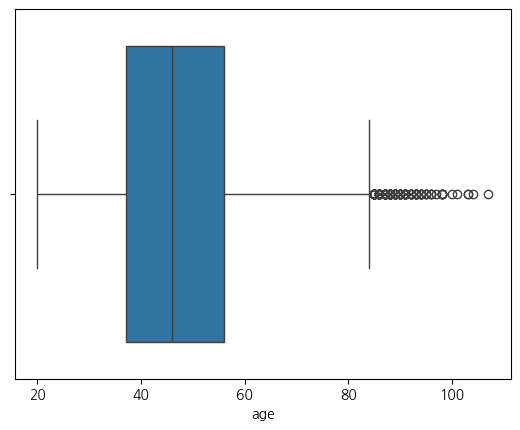

In [35]:
sns.boxplot(data=data_df, x='age')
plt.show()

### 범주형 처리

제외 columns
- id
- bank
- datetime

In [36]:
remove_columns = ['id', 'bank', 'datetime']
missing_columns = ['credit rating', 'age', 'Mileage'] # 'bank'
final_lable_columns = ['amount', 'state', 'overdue']

In [37]:
remove_df = data_df.drop(columns=remove_columns)
remove_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_of_contract   51304 non-null  object 
 1   type_of_contract2  51304 non-null  object 
 2   channel            51304 non-null  object 
 3   Term               51304 non-null  int64  
 4   payment_type       51304 non-null  object 
 5   product            51304 non-null  object 
 6   amount             51304 non-null  int64  
 7   state              51304 non-null  object 
 8   overdue_count      51304 non-null  int64  
 9   overdue            51304 non-null  object 
 10  credit rating      42521 non-null  float64
 11  cancellation       51304 non-null  object 
 12  age                40509 non-null  float64
 13  Mileage            40509 non-null  float64
dtypes: float64(3), int64(3), object(8)
memory usage: 5.5+ MB


In [38]:
missing_df = remove_df.drop(columns=missing_columns)
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type_of_contract   51304 non-null  object
 1   type_of_contract2  51304 non-null  object
 2   channel            51304 non-null  object
 3   Term               51304 non-null  int64 
 4   payment_type       51304 non-null  object
 5   product            51304 non-null  object
 6   amount             51304 non-null  int64 
 7   state              51304 non-null  object
 8   overdue_count      51304 non-null  int64 
 9   overdue            51304 non-null  object
 10  cancellation       51304 non-null  object
dtypes: int64(3), object(8)
memory usage: 4.3+ MB


In [39]:
cat_df, num_df = split_categorical_numerical(missing_df)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type_of_contract   51304 non-null  object
 1   type_of_contract2  51304 non-null  object
 2   channel            51304 non-null  object
 3   Term               51304 non-null  int64 
 4   payment_type       51304 non-null  object
 5   product            51304 non-null  object
 6   state              51304 non-null  object
 7   overdue_count      51304 non-null  int64 
 8   overdue            51304 non-null  object
 9   cancellation       51304 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


In [40]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   amount  51304 non-null  int64
dtypes: int64(1)
memory usage: 400.9 KB


In [41]:
def run_onehotencode(data_df, model=OneHotEncoder()):

    columns = data_df.columns
    model_list = []
    for col in columns :
        model.fit(X=data_df[[col]])
        model_list.append(deepcopy(model))
        encoded_pclass = model.transform(X=data_df[[col]]).toarray()
        pclass_name_list = model.get_feature_names_out(input_features=[col])
        pclass_df = pd.DataFrame(data=encoded_pclass, columns=pclass_name_list, index=data_df.index)
        # 원본 자르는거 추가 

        data_df = pd.concat([data_df.drop(columns=[col]), pclass_df], axis=1)

    return data_df, model_list

In [42]:
onehot_df, model_list = run_onehotencode(cat_df)
missing_df = pd.concat([onehot_df, num_df], axis=1)
missing_df.head()

,type_of_contract_렌탈,type_of_contract_멤버십,type_of_contract2_Extension_Rental,type_of_contract2_Group,type_of_contract2_Normal,type_of_contract2_Package,type_of_contract2_Packge,type_of_contract2_Promotion,type_of_contract2_TA1,type_of_contract2_TA2,...,overdue_count_11,overdue_count_12,overdue_count_13,overdue_count_14,overdue_count_15,overdue_없음,overdue_있음,cancellation_정상,cancellation_해약,amount
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,96900
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,102900
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,96900
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,66900
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,66900


In [43]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 73 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   type_of_contract_렌탈                 51304 non-null  float64
 1   type_of_contract_멤버십                51304 non-null  float64
 2   type_of_contract2_Extension_Rental  51304 non-null  float64
 3   type_of_contract2_Group             51304 non-null  float64
 4   type_of_contract2_Normal            51304 non-null  float64
 5   type_of_contract2_Package           51304 non-null  float64
 6   type_of_contract2_Packge            51304 non-null  float64
 7   type_of_contract2_Promotion         51304 non-null  float64
 8   type_of_contract2_TA1               51304 non-null  float64
 9   type_of_contract2_TA2               51304 non-null  float64
 10  type_of_contract2_TA3               51304 non-null  float64
 11  type_of_contract2_TAS               51304

### 스케일링

In [44]:
# 일단 통짜로 돌려보고 데이터 특성에 따라 따로 돌리는 거를 고려해 보아야 할 듯?
standardscaler = StandardScaler()
standardscaler.fit(missing_df)

StandardScaler()

In [45]:
# 스케일링 적용
scaling_array = standardscaler.transform(missing_df)
# 스케일링된 데이터를 DataFrame으로 변환
scaling_df = pd.DataFrame(scaling_array, columns=missing_df.columns)
scaling_df.head()

,type_of_contract_렌탈,type_of_contract_멤버십,type_of_contract2_Extension_Rental,type_of_contract2_Group,type_of_contract2_Normal,type_of_contract2_Package,type_of_contract2_Packge,type_of_contract2_Promotion,type_of_contract2_TA1,type_of_contract2_TA2,...,overdue_count_11,overdue_count_12,overdue_count_13,overdue_count_14,overdue_count_15,overdue_없음,overdue_있음,cancellation_정상,cancellation_해약,amount
0,0.321975,-0.321975,-0.327695,-0.060969,1.532302,-0.49766,-0.004415,-0.667434,-0.01592,-0.205922,...,-0.033056,-0.046983,-0.029298,-0.029629,-0.014644,0.211214,-0.211214,0.134153,-0.134153,0.189809
1,0.321975,-0.321975,3.051616,-0.060969,-0.652613,-0.49766,-0.004415,-0.667434,-0.01592,-0.205922,...,-0.033056,-0.046983,-0.029298,-0.029629,-0.014644,0.211214,-0.211214,0.134153,-0.134153,0.581837
2,0.321975,-0.321975,-0.327695,-0.060969,1.532302,-0.49766,-0.004415,-0.667434,-0.01592,-0.205922,...,-0.033056,-0.046983,-0.029298,-0.029629,-0.014644,0.211214,-0.211214,0.134153,-0.134153,0.189809
3,-3.105832,3.105832,-0.327695,-0.060969,-0.652613,-0.49766,-0.004415,-0.667434,-0.01592,-0.205922,...,-0.033056,-0.046983,-0.029298,-0.029629,-0.014644,0.211214,-0.211214,0.134153,-0.134153,-1.770335
4,-3.105832,3.105832,-0.327695,-0.060969,-0.652613,-0.49766,-0.004415,-0.667434,-0.01592,-0.205922,...,-0.033056,21.284212,-0.029298,-0.029629,-0.014644,-4.734532,4.734532,-7.454160,7.454160,-1.770335


##### 결측치 ML 로 채우기
- 일단 credit rating 은 범주로 채우고
- age, Mileage 는 연속으로 채우자
- 범주로 채우면, class가 늘어나지 않음.
- 연속으로 채우면, class가 늘어남. 이 경우를 염두에 두어야함.

In [46]:
data_df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   credit rating  42521 non-null  float64
 1   age            40509 non-null  float64
 2   Mileage        40509 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [47]:
# label에서 NaN을 제거한 후 인덱스를 가져옵니다.
label = data_df[missing_columns[0]].dropna()
features = scaling_df.loc[label.index]
features.columns

Index(['type_of_contract_렌탈', 'type_of_contract_멤버십',
       'type_of_contract2_Extension_Rental', 'type_of_contract2_Group',
       'type_of_contract2_Normal', 'type_of_contract2_Package',
       'type_of_contract2_Packge', 'type_of_contract2_Promotion',
       'type_of_contract2_TA1', 'type_of_contract2_TA2',
       'type_of_contract2_TA3', 'type_of_contract2_TAS', 'channel_R관리방판',
       'channel_R농협', 'channel_R농협인터넷몰', 'channel_R렌탈운영', 'channel_R법인',
       'channel_R법인그룹', 'channel_R빌리미', 'channel_R유통사', 'channel_R인터넷',
       'channel_렌탈재계약', 'channel_렌탈총판', 'channel_서비스 방문', 'channel_영업방판',
       'channel_이마트', 'channel_일반', 'channel_전자랜드', 'channel_하이마트',
       'channel_홈쇼핑/방송', 'channel_홈쇼핑/인터넷', 'channel_홈플러스', 'Term_12',
       'Term_36', 'Term_39', 'Term_60', 'payment_type_CMS',
       'payment_type_가상계좌', 'payment_type_무통장', 'payment_type_지로',
       'payment_type_카드이체', 'product_K1', 'product_K2', 'product_K3',
       'product_K4', 'product_K5', 'product_K6', 'state_계약

In [48]:
labelencoder = LabelEncoder()
labelencoder.fit(label)
encoded_label = labelencoder.transform(label)
encoded_label

array([9, 2, 8, ..., 1, 2, 8])

In [49]:
model_randomforestclassifier = RandomForestClassifier(random_state=32)
model_randomforestclassifier.fit(X=features,y=label)

RandomForestClassifier(random_state=32)

In [50]:
predictions = model_randomforestclassifier.predict(features)
print(classification_report(y_true=label, y_pred=predictions))
accuracy_score(y_true=label,y_pred=predictions)

              precision    recall  f1-score   support

         0.0       1.00      0.13      0.24        60
         1.0       0.29      0.86      0.44     10778
         2.0       0.24      0.18      0.21      8228
         3.0       0.29      0.06      0.10      4997
         4.0       0.32      0.06      0.11      5379
         5.0       0.40      0.05      0.09      4317
         6.0       0.41      0.08      0.13      3818
         7.0       0.57      0.11      0.18      2717
         8.0       0.58      0.15      0.24      1542
         9.0       0.67      0.15      0.24       639
        10.0       0.50      0.11      0.18        46

    accuracy                           0.30     42521
   macro avg       0.48      0.18      0.20     42521
weighted avg       0.34      0.30      0.22     42521



0.297006185179088

In [51]:
diff = label - predictions
diff.abs().mean(), diff.mean()

(2.075374520825004, 1.8482867289104208)

In [52]:
predict_score = model_randomforestclassifier.predict_proba(X=features) # 주로 수가 많은 쪽 class를 양성으로 정함
AUC_score = roc_auc_score(y_true=label, y_score=predict_score, multi_class='ovr')
AUC_score

0.7180297057357219

In [53]:
smote = SMOTE()
feature_smote, label_smote = smote.fit_resample(X=features, y=label)

In [54]:
len(features), len(feature_smote), len(label), len(label_smote)


(42521, 118558, 42521, 118558)

In [55]:
model_randomforestclassifier_smote = RandomForestClassifier(random_state=32)
model_randomforestclassifier_smote.fit(X=feature_smote,y=label_smote)

RandomForestClassifier(random_state=32)

In [56]:
predictions = model_randomforestclassifier_smote.predict(feature_smote)
print(classification_report(y_true=label_smote, y_pred=predictions))
accuracy_score(y_true=label_smote,y_pred=predictions)

              precision    recall  f1-score   support

         0.0       0.53      0.89      0.66     10778
         1.0       0.21      0.44      0.29     10778
         2.0       0.38      0.06      0.10     10778
         3.0       0.27      0.22      0.25     10778
         4.0       0.45      0.11      0.17     10778
         5.0       0.32      0.19      0.24     10778
         6.0       0.46      0.18      0.26     10778
         7.0       0.41      0.27      0.33     10778
         8.0       0.34      0.53      0.41     10778
         9.0       0.45      0.54      0.49     10778
        10.0       0.59      0.97      0.73     10778

    accuracy                           0.40    118558
   macro avg       0.40      0.40      0.36    118558
weighted avg       0.40      0.40      0.36    118558



0.3996103173130451

In [57]:
diff = label_smote - predictions
diff.abs().mean(), diff.mean()

(2.2762361038479058, -0.03532448253175661)

In [58]:
predict_score = model_randomforestclassifier_smote.predict_proba(X=feature_smote) # 주로 수가 많은 쪽 class를 양성으로 정함
AUC_score = roc_auc_score(y_true=label_smote, y_score=predict_score, multi_class='ovr')
AUC_score

0.8055690451296182

In [59]:
missing_mask = data_df[missing_columns[0]].isna()
missing_records = scaling_df.loc[missing_mask.index]
predictions_smote = model_randomforestclassifier_smote.predict(missing_records)

In [60]:
missing_mask = data_df[missing_columns[0]].isna()
missing_records = scaling_df.loc[missing_mask.index]
predictions = model_randomforestclassifier.predict(missing_records)

In [61]:
diff = predictions_smote - predictions
abs_array = np.abs(diff)
diff.mean(), abs_array.mean()

(2.523857788866365, 2.818142834866677)

In [62]:
predictions_smote

array([0., 1., 9., ..., 1., 3., 8.])

In [63]:
data_df.loc[missing_mask.index, missing_columns[0]] = predictions_smote

In [64]:
data_df.loc[missing_mask.index, missing_columns[0]] = predictions

In [65]:
data_df[missing_columns[0]].value_counts() 

credit rating
1.0     35166
2.0      7847
3.0      3378
4.0      1478
6.0       947
7.0       897
5.0       790
8.0       533
9.0       173
0.0        84
10.0       11
Name: count, dtype: int64

In [66]:
# label에서 NaN을 제거한 후 인덱스를 가져옵니다.
label = data_df[missing_columns[1]].dropna()
features = scaling_df.loc[label.index]

In [67]:
model_randomforestregressor = RandomForestRegressor(random_state=32)
model_randomforestregressor.fit(X=features,y=label)

RandomForestRegressor(random_state=32)

In [68]:
predictions = model_randomforestregressor.predict(features)
r2 = r2_score(y_true=label,y_pred=predictions)
# rmse = root_mean_squared_error(y_true=label, y_pred=predictions)
# r2, rmse
r2

0.033399120477535904

In [69]:
diff = label - predictions
diff.abs().mean(), diff.mean()

(10.72840166443053, -0.015954786499592363)

In [70]:
missing_mask = data_df[missing_columns[1]].isna()
missing_records = scaling_df.loc[missing_mask.index]
predictions = model_randomforestregressor.predict(missing_records)
data_df.loc[missing_mask.index, missing_columns[1]] = predictions

In [71]:
data_df.loc[missing_mask.index, missing_columns[1]] = data_df.loc[missing_mask.index, missing_columns[1]].astype(float).round(0).astype(int)
data_df.loc[missing_mask.index, missing_columns[1]]

0        46.0
1        47.0
2        47.0
3        47.0
4        46.0
         ... 
51299    47.0
51300    40.0
51301    48.0
51302    48.0
51303    47.0
Name: age, Length: 51304, dtype: float64

In [72]:
label = data_df[missing_columns[2]].dropna()
features = scaling_df.loc[label.index]

In [73]:
model_randomforestregressor = RandomForestRegressor(random_state=32)
model_randomforestregressor.fit(X=features,y=label)

RandomForestRegressor(random_state=32)

In [74]:
predictions = model_randomforestregressor.predict(features)
r2 = r2_score(y_true=label,y_pred=predictions)
# rmse = root_mean_squared_error(y_true=label, y_pred=predictions)
r2 # , rmse

0.03341281456041556

In [75]:
diff = label - predictions
diff.abs().mean(), diff.mean()

(346.8522727913435, -0.5592174592914608)

In [76]:
missing_mask = data_df[missing_columns[2]].isna()
missing_records = scaling_df.loc[missing_mask.index]
predictions = model_randomforestregressor.predict(missing_records)
data_df.loc[missing_mask.index, missing_columns[2]] = predictions

In [77]:
data_df.loc[missing_mask.index, missing_columns[2]] = data_df.loc[missing_mask.index, missing_columns[2]].astype(float).round(0).astype(int)
data_df.loc[missing_mask.index, missing_columns[2]]

0        1956.0
1        1976.0
2        1971.0
3        1993.0
4        1896.0
          ...  
51299    1988.0
51300    1794.0
51301    2078.0
51302    2011.0
51303    1995.0
Name: Mileage, Length: 51304, dtype: float64

In [78]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 51304 non-null  int64  
 1   type_of_contract   51304 non-null  object 
 2   type_of_contract2  51304 non-null  object 
 3   channel            51304 non-null  object 
 4   datetime           51304 non-null  object 
 5   Term               51304 non-null  int64  
 6   payment_type       51304 non-null  object 
 7   product            51304 non-null  object 
 8   amount             51304 non-null  int64  
 9   state              51304 non-null  object 
 10  overdue_count      51304 non-null  int64  
 11  overdue            51304 non-null  object 
 12  credit rating      51304 non-null  float64
 13  bank               48544 non-null  object 
 14  cancellation       51304 non-null  object 
 15  age                51304 non-null  float64
 16  Mileage            513

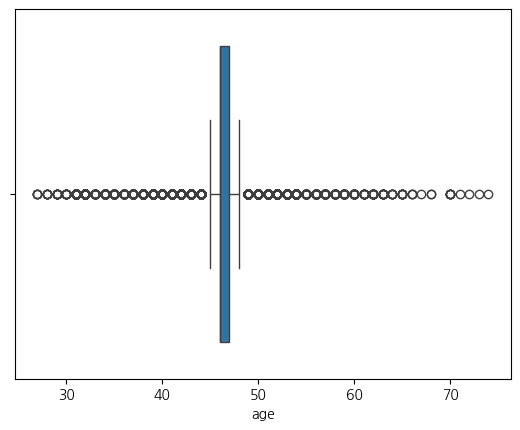

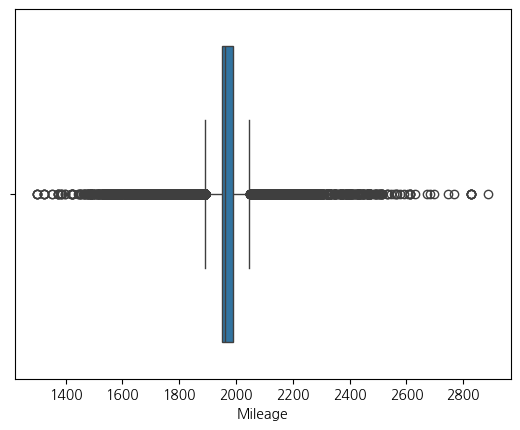

In [79]:
sns.boxplot(data=data_df, x='age')
plt.show()
sns.boxplot(data=data_df, x='Mileage')
plt.show()

##### 최종 encode 와 scaling 수행

- 아얘 나눠야 되
- amount 용 이랑, state 용 이랑, overdue 용으로 dataset 분리 필요 

In [80]:
remove_df = data_df.drop(columns=remove_columns)
remove_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51304 entries, 0 to 51303
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type_of_contract   51304 non-null  object 
 1   type_of_contract2  51304 non-null  object 
 2   channel            51304 non-null  object 
 3   Term               51304 non-null  int64  
 4   payment_type       51304 non-null  object 
 5   product            51304 non-null  object 
 6   amount             51304 non-null  int64  
 7   state              51304 non-null  object 
 8   overdue_count      51304 non-null  int64  
 9   overdue            51304 non-null  object 
 10  credit rating      51304 non-null  float64
 11  cancellation       51304 non-null  object 
 12  age                51304 non-null  float64
 13  Mileage            51304 non-null  float64
dtypes: float64(3), int64(3), object(8)
memory usage: 5.5+ MB


In [81]:
data_df_list = [remove_df.drop(columns=label) for label in final_lable_columns]

In [82]:
scaling_df_list = []
encode_model_list_list = []
scaler_model_list = []
for df in data_df_list:
    cat_df, num_df = split_categorical_numerical(df)
    
    onehot_df, model_list = run_onehotencode(cat_df)
    encode_df = pd.concat([onehot_df, num_df], axis=1)
    
    standardscaler = StandardScaler()
    standardscaler.fit(encode_df)

    scaling_array = standardscaler.transform(encode_df)
    scaling_df = pd.DataFrame(scaling_array, columns=encode_df.columns)

    scaling_df_list.append(scaling_df)
    scaler_model_list.append(standardscaler)
    encode_model_list_list.append(model_list)


In [83]:
label_encode_model_list = []
label_encode_list = []
for col in final_lable_columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_df[col])
    encoded_label = labelencoder.transform(data_df[col])
    label_encode_list.append(encoded_label)
    label_encode_model_list.append(labelencoder)

### 리샘플링 

## 데이터 분할

In [84]:
test_size = 0.2
random_state = 42

train_features_list = []
test_features_list = []
train_label_list = []
test_label_list = []

for num, df in enumerate(scaling_df_list):
    train_features, test_features, train_label, test_label =\
        train_test_split(df, label_encode_list[num], test_size=test_size, random_state=random_state)
    train_features_list.append(train_features)
    test_features_list.append(test_features)
    train_label_list.append(train_label)
    test_label_list.append(test_label)

## 모델 학습 

In [85]:
def train_model(X_train, y_train, model):
    """
    모델 학습을 수행하는 함수
    
    Parameters:
    - X_train: 학습 데이터
    - y_train: 학습 레이블
    - model: 학습할 모델 객체
    
    Returns:
    - trained_model: 학습된 모델
    """
    trained_model = model.fit(X_train, y_train)
    return trained_model

In [128]:
def evaluate_model(trained_model, X_test, y_test, task_type='regression'):
    """
    학습된 모델을 평가하는 함수
    
    Parameters:
    - trained_model: 학습된 모델
    - X_test: 테스트 데이터
    - y_test: 테스트 레이블
    - task_type: 'regression' 또는 'classification'
    
    Returns:
    - results: 평가 결과 딕셔너리
    """
    y_pred = trained_model.predict(X_test)
    results = {}
    
    if task_type == 'regression':
        results['mse'] = mean_squared_error(y_test, y_pred)
        results['rmse'] = np.sqrt(results['mse'])
        results['r2'] = r2_score(y_test, y_pred)
    else:  # classification
        results['accuracy'] = accuracy_score(y_test, y_pred)
        results['classification_report'] = classification_report(y_test, y_pred)
        y_pred_proba = trained_model.predict_proba(X_test)
        if task_type == 'binary':
            FPR, TPR, threshold = roc_curve(y_true=y_test, y_score=y_pred_proba[:, 0])
            results['auc_score'] = auc(FPR, TPR)
        else:  # multiclass
            results['auc_score'] = roc_auc_score(y_true=y_test, y_score=y_pred_proba, multi_class='ovr')
    
    return results

In [109]:
def run_model_comparison(X_train, X_test, y_train, y_test, models, task_type='regression'):
    """
    여러 모델을 학습하고 평가하는 통합 함수
    
    Parameters:
    - X_train, X_test: 학습/테스트 데이터
    - y_train, y_test: 학습/테스트 레이블
    - models: 모델 딕셔너리
    - task_type: 'regression', 'binary' 또는 'multiclass'
    
    Returns:
    - all_results: 모든 모델의 평가 결과
    - trained_models: 학습된 모델들
    """
    all_results = {}
    trained_models = {}
    
    # 다중 분류인 경우 클래스 수 계산
    # n_classes = len(np.unique(y_train)) if task_type == 'multiclass' else None
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # 모델 학습
        trained_model = train_model(X_train, y_train, model)
        trained_models[model_name] = trained_model
        
        # 모델 평가
        results = evaluate_model(trained_model, X_test, y_test, task_type)
        all_results[model_name] = results
        
        # 결과 출력
        print(f"\n{model_name} Results:")
        for metric, value in results.items():
            if isinstance(value, str):  # classification_report의 경우
                print(f"\n{metric}:\n{value}")
            else:
                print(f"{metric}: {value:.4f}")
    
    return all_results, trained_models


In [100]:
data_df[final_lable_columns[1]].value_counts()

state
계약확정     50350
해약확정       907
기간만료        33
해약진행중       14
Name: count, dtype: int64

In [99]:
train_label_list[1][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [101]:
label_encode_model_list[1].classes_


array(['계약확정', '기간만료', '해약진행중', '해약확정'], dtype=object)

In [102]:
model_svc = RandomForestClassifier()
model_svc.fit(X=train_features_list[1],y=train_label_list[1])

RandomForestClassifier()

In [103]:
predict_score = model_svc.predict_proba(X=train_features_list[1]) # 주로 수가 많은 쪽 class를 양성으로 정함
predict_score[:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [104]:
AUC_score = roc_auc_score(y_true=train_label_list[1], y_score=predict_score, multi_class='ovr')
AUC_score

1.0

In [111]:
# 모델 정의
models = {
    'regression': {
        'RandomForestRegressor': RandomForestRegressor(),
        # 'SVR': SVR(),
        'LinearRegression': LinearRegression()
    },
    'binary': {
        'RandomForestClassifier': RandomForestClassifier(),
        # 'SVC': SVC(probability=True),
        'LogisticRegression': LogisticRegression()
    },
    'multiclass': {
        'RandomForestClassifier': RandomForestClassifier(),
        # 'SVC': SVC(probability=True, decision_function_shape='ovr'),
        'LogisticRegression': LogisticRegression()
    }
}

# 연속형 레이블에 대한 모델 학습 및 평가
print("\nRegression Task Results:")
reg_results, reg_models = run_model_comparison(
    train_features_list[0], 
    train_features_list[0], 
    train_label_list[0], 
    train_label_list[0], 
    models['regression'],
    'regression'
)



Regression Task Results:

Training RandomForestRegressor...

RandomForestRegressor Results:
mse: 0.7590
rmse: 0.8712
r2: 0.9966

Training LinearRegression...

LinearRegression Results:
mse: 56.6662
rmse: 7.5277
r2: 0.7459


In [ ]:
# 이진 분류에 대한 모델 학습 및 평가
print("\nBinary Classification Task Results:")
binary_results, binary_models = run_model_comparison(
    train_features_list[2], 
    train_features_list[2], 
    train_label_list[2], 
    train_label_list[2], 
    models['binary'],
    'binary'
)

In [129]:
# 다중 분류에 대한 모델 학습 및 평가
print("\nMulticlass Classification Task Results:")
multi_results, multi_models = run_model_comparison(
    train_features_list[1], 
    train_features_list[1], 
    train_label_list[1], 
    train_label_list[1], 
    models['multiclass'],
    'multiclass'
)


Multiclass Classification Task Results:

Training RandomForestClassifier...

RandomForestClassifier Results:
accuracy: 1.0000

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40280
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00       725

    accuracy                           1.00     41043
   macro avg       1.00      1.00      1.00     41043
weighted avg       1.00      1.00      1.00     41043

auc_score: 1.0000

Training LogisticRegression...

LogisticRegression Results:
accuracy: 0.9997

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40280
           1       0.96      0.96      0.96        26
           2       0.75      0.25      0.38        12
           3       1.00      1.00      1.00       725

    accuracy          

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 모델 평가 

#### 결과 평가
- Classification이 지나치게 결과 좋다, 아마 강한 상관관계 있는 컬럼의 data leakage 문제 인듯 하다.


In [121]:
def eval_model_comparison( X_test, y_test, models, task_type='regression'):
    """
    여러 모델을 학습하고 평가하는 통합 함수
    
    Parameters:
    - X_train, X_test: 학습/테스트 데이터
    - y_train, y_test: 학습/테스트 레이블
    - models: 모델 딕셔너리
    - task_type: 'regression', 'binary' 또는 'multiclass'
    
    Returns:
    - all_results: 모든 모델의 평가 결과
    - trained_models: 학습된 모델들
    """
    all_results = {}
    trained_models = {}
    
    # 다중 분류인 경우 클래스 수 계산
    # n_classes = len(np.unique(y_train)) if task_type == 'multiclass' else None
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        # 모델 평가
        results = evaluate_model(model, X_test, y_test, task_type)
        all_results[model_name] = results
        
        # 결과 출력
        print(f"\n{model_name} Results:")
        for metric, value in results.items():
            if isinstance(value, str):  # classification_report의 경우
                print(f"\n{metric}:\n{value}")
            else:
                print(f"{metric}: {value:.4f}")
    
    return all_results


In [122]:
# 연속형 레이블에 대한 모델 학습 및 평가
print("\nRegression Task Results:")
reg_eval_results = eval_model_comparison(
    test_features_list[0], 
    test_label_list[0], 
    reg_models,
    'regression'
)


Regression Task Results:

Evaluating RandomForestRegressor...

RandomForestRegressor Results:
mse: 4.7653
rmse: 2.1830
r2: 0.9790

Evaluating LinearRegression...

LinearRegression Results:
mse: 57.6130
rmse: 7.5903
r2: 0.7456


In [123]:
# 이진 분류에 대한 모델 학습 및 평가
print("\nBinary Classification Task Results:")
binary_eval_results = eval_model_comparison(
    test_features_list[2], 
    test_label_list[2], 
    binary_models,
    'binary'
)


Binary Classification Task Results:

Evaluating RandomForestClassifier...

RandomForestClassifier Results:
accuracy: 1.0000

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9796
           1       1.00      1.00      1.00       465

    accuracy                           1.00     10261
   macro avg       1.00      1.00      1.00     10261
weighted avg       1.00      1.00      1.00     10261

auc_score: 0.0000

Evaluating LogisticRegression...

LogisticRegression Results:
accuracy: 1.0000

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9796
           1       1.00      1.00      1.00       465

    accuracy                           1.00     10261
   macro avg       1.00      1.00      1.00     10261
weighted avg       1.00      1.00      1.00     10261

auc_score: 0.0000


In [130]:
# 다중 분류에 대한 모델 학습 및 평가
print("\nMulticlass Classification Task Results:")
multi_eval_results = eval_model_comparison(
    test_features_list[1], 
    test_label_list[1], 
    multi_models,
    'multiclass'
)


Multiclass Classification Task Results:

Evaluating RandomForestClassifier...

RandomForestClassifier Results:
accuracy: 0.9996

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10070
           1       1.00      0.57      0.73         7
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00       182

    accuracy                           1.00     10261
   macro avg       1.00      0.77      0.85     10261
weighted avg       1.00      1.00      1.00     10261

auc_score: 1.0000

Evaluating LogisticRegression...

LogisticRegression Results:
accuracy: 0.9995

classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10070
           1       0.83      0.71      0.77         7
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00       182

    accuracy      

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 모델 배포